# Gaining knowledge from tests
#### Max Collard, September 2021

# A clairvoyant mouse?

You look at your data, and you see that you **reject the null hypothesis** that *your mouse's neurons contain no information about the future* with a $p$-value of 0.014.

### What do you do with this information?

# Let's think about it another way

For the last four weeks, you've been doing nothing but sitting in your room alone studying for your qualifying exam, with **absolutely zero human contact**.

You take it and pass—**hooray!**

But while you've been away studying, UCSF has announced a new policy requiring all graduate students to be tested for Covid-19 daily. You must provide a negative test result before entering any research building on-campus! (*No, not really.*)

You grab a test from one of the Color vending machines and wait at home for the results to come back. The next day, you get the dreaded email:

`SARS-CoV-2 Antigen:    DETECTED`

### What do you do with this information?

# Do you think you have Covid?

## Why do you think that?

# Let's scale it up

Right now (9/1/21), the prevalence of Covid in San Francisco is about 350 per 100,000. If you were to pick a person at random from San Francisco with no other knowledge, this would be the chance of picking someone who currently has Covid.

In [2]:
covid_prevalence = 350 / 100000

Recall that the $p$-value is defined by thinking about what our observations would be by chance if we **pre-suppose that the null hypothesis is in fact true**:

$$ p = \mathrm{Pr}(\textrm{we observe a difference} \mid \textrm{there is no difference}) $$

> This is convenient to use, because we can always **impose** the null hypothesis by shuffling our data. This is called **permutation testing**.

Usually, diagnostic tests are evaluated kind of like $p$-values: we use measures that ask how the *test* behaves when we **pre-suppose the truth**.

**Sensitivity** measures the probability that a person tests positive **given** that they actually have the disease:

$$ \mathrm{sensitivity} = \mathrm{Pr}(\textrm{test }+ \mid \textrm{actually }+) $$

**Specificity** measures the probability that a person tests negative **given** that they actually *do not* have the disease,

$$ \mathrm{specificity} = \mathrm{Pr}(\textrm{test }- \mid \textrm{actually }-) $$

#### N.B.

The $p$-value can be thought of as

$$ p = \mathrm{Pr}(\textrm{test }+ \mid \textrm{actually }-) $$

Because there are only two test outcomes, $+$ and $-$, this means that

$$ p = 1 - \mathrm{specificity} $$

Let's suppose that the currently used RT-PCR test for Covid has approximately the following characteristics:

In [2]:
rtpcr_sensitivity = 0.777
rtpcr_specificity = 0.988

> (These are based on contemporary literature, although finding these values is quite challenging in practice.)

# You just got a positive test.

## What do the sensitivity and specificity tell you?

# Predictive value

You already **know** that you've tested positive. What you would like to **infer** is whether or not you actually have Covid.

## Sensitivity and specificity do not tell you this

(And so, neither do **$p$-values**!)

What you want to know are the quantities with the **opposite conditioning**: we **know** the test result once we get it, but we must **infer** the truth about whether we actually have Covid **given** that test result.

**Positive predictive value** is the probability one *actually has the disease* **given** a positive test result:

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+) $$

Now that you have a positive Covid test, the **PPV** is the probability that you **actually** have Covid.

**Negative predictive value** is the probability one *actually does not have the disease* **given** a negative test result:

$$ \mathrm{NPV} = \mathrm{Pr}(\textrm{actually }- \mid \textrm{test }-) $$

### What do you think are the PPV and NPV for the RT-PCR test?

In [3]:
import numpy as np

# I'm going to be re-using this simulation a lot, so I'll make it a function
def sample_results( n, prevalence, sensitivity, specificity ):
    
    # First, simulate the "truth":
    # The fraction of the time that a uniform random number between 0 and 1
    # is below `prevalence` is ... `prevalence`!
    has_disease = np.random.uniform( size = (n,) ) < prevalence
    
    # Now, use sensitivity and specificity to determine test results based on the truth
    
    # Pre-allocate where I'm going to store the results
    test_results = np.zeros( (n,), dtype = bool )
    # We need a "hidden" random variable to determine the results of each test
    hidden_randoms = np.random.uniform( size = (n,) )
    
    # Iterate over each individual in the population
    # N.B.: I'm doing some Python magic here:
    # * `enumerate` allows me to iterate through a something and also keep track of its index
    # * `zip` allows me to "glue together" two iterable things (like arrays) element by element.
    # Writing my code this way helps prevent me from losing track of what index belongs to what
    for i_individual, (individual_has_disease, individual_hidden) in enumerate( zip( has_disease, hidden_randoms ) ):
        if individual_has_disease:
            # As above, this will be true `sensitivity` portion of the time
            if individual_hidden < sensitivity:
                # *Given* the individual has the disease, `sensitivity` portion of the time,
                # the person will test *positive*
                test_results[i_individual] = True
            else:
                # ... otherwise, they test negative
                test_results[i_individual] = False
        else:
            if individual_hidden < specificity:
                # *Given* the individual *does not* have the disease, `specificity` portion of the time,
                # the person will test *negative*
                test_results[i_individual] = False
            else:
                # ... otherwise, they test positive
                test_results[i_individual] = True
    
    return has_disease, test_results

Let's simulate one day's worth of Covid tests at UCSF:

In [4]:
# Approximately the number of employees at UCSF
n_employees = 24000
# Run our simulation and grab the results
has_covid, rtpcr_positive = sample_results( n_employees,
                                            covid_prevalence,
                                            rtpcr_sensitivity,
                                            rtpcr_specificity )

# If I put an f in front of my string, I can use curly braces to put Python code inside of it
print( f'Cases today: {np.sum( has_covid )}' )
print( f'Positive tests today: {np.sum( rtpcr_positive )}' )

Cases today: 86
Positive tests today: 353


Clearly something funky is going on: there are way more positive tests than cases!

As is always good practice, let's take a look at a subsample of the raw data:

In [5]:
import matplotlib.pyplot as plt

# I'm going to make the same plot later, so I'll make a function I can reuse so I don't duplicate code
def sample_plot( ax, has_disease, test_results,
                 n_sample = 1000 ):

    # np.c_ takes two arrays and jams them together as *c*olumns
    # Then, .T *T*ransposes it, so that they're rows
    raster = np.c_[has_disease, test_results].T.astype( float )
    # I only want to display a little part of the whole raster, cause it's huge, so I slice it with :
    raster = raster[:, :n_sample]
    
    # I'm assuming here that I've created an "axes" object that I can plot inside of
    # This makes it so that I can re-use the same function on multiple plots in the same figure!
    ax.imshow( raster,
               aspect = 'auto',
               interpolation = 'none', ) # These are just my personal preferences for image plots

    ax.set_xlabel( 'Sample #' )
    
    ax.set_yticks( [0, 1] )
    ax.set_yticklabels( ['Has Covid?', 'Test Result'],
                        rotation = 45 )

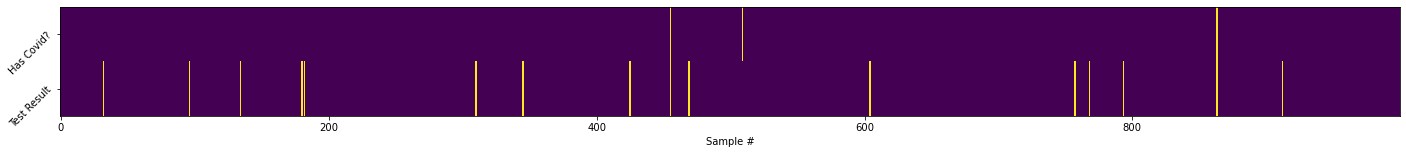

In [6]:
# Subplots allows us to lay out some axes (`ax`) inside of a figure (`fig`) that we can manipulate later
fig, ax = plt.subplots( figsize = (24, 2) )
# Use the plotting function we just made on these axes
sample_plot( ax, has_covid, rtpcr_positive )
# We're all done building the plots, we want to displaly them now
plt.show()

By eye, it *definitely* looks like there are a lot of false positives.

In [7]:
# Again, I'm going to be doing these computations a lot, so I'll make a function I can re-use
def predictive_value( has_disease, test_results ):
    # PPV
    n_test_pos = np.sum( test_results )
    # & operates on boolean arrays element by element
    # So `a & b` is an array where each entry is `True` if the corresponding entries of both
    # `a` and `b` are both `True`
    # True positives are those that have the disease *and* test positive
    n_true_pos = np.sum( has_disease & test_results )
    ppv = n_true_pos / n_test_pos
    # NPV
    # ~ operates on boolean arrays element by element
    # So `~a` is an array where each entry is `True` if the corresponding entry of `a` is `False`
    n_test_neg = np.sum( ~test_results )
    # True negatives are those that *do not* have the disease *and* *do not* test positive
    n_true_neg = np.sum( (~has_disease) & (~test_results) )
    npv = n_true_neg / n_test_neg
    
    return ppv, npv

### What are the PPV and NPV?

In [8]:
ppv_naive, npv_naive = predictive_value( has_covid, rtpcr_positive )

# We can do math in our curly braces; here I convert the ratios into percents
# The `:0.2f` at the end tells Python that I want 2 digits after the decimal point
# (not at all intuitive; blame the C people who wrote the original `printf`)
print( f'Naive PPV: {ppv_naive * 100:0.2f}%' )
print( f'Naive NPV: {npv_naive * 100:0.2f}%' )

Naive PPV: 17.85%
Naive NPV: 99.90%


Let's talk about the good news first: 

* A *negative* test is **extremely informative**: if you receive a negative test result, you can say with almost certainty that you are in the clear.

* *However*, in this setup, a *positive* test is **not very informative**: in fact, if you were to receive a positive RT-PCR test, *there is an ~85% chance that you still don't have Covid*. Put another way, **more than 4 out of every 5 positive tests are actually false positives**.

This screening procedure is going to result in hundreds of people being sent into quarantine every day; in fact, if quarantine lasts for two work weeks, then to a first approximation, about 13% of the entire workforce will be quarantining at any given moment from false positive tests alone:

In [9]:
quarantine_workdays = 10
# False positives *do not* have Covid *and* test positive
quarantine_false_positives_per_day = np.sum( ~has_covid & rtpcr_positive )
quarantine_false_positives_simultaneous = quarantine_false_positives_per_day * quarantine_workdays
quarantine_fraction = quarantine_false_positives_simultaneous / n_employees

print( f'Fraction of workforce quarantined: {quarantine_fraction * 100:0.2f}%' )

Fraction of workforce quarantined: 12.08%


#### N.B.

This test also has an extremely high **accuracy**, which is the probability of the test being *correct*:

In [10]:
# == operates element by element on arrays
# `a == b` is an array where each element is `True` if the corresponding elements of
# `a` and `b` are equal
accuracy_naive = np.sum( has_covid == rtpcr_positive ) / len( has_covid )

print( f'Naive accuracy: {accuracy_naive * 100:0.2f}%' )

Naive accuracy: 98.70%


But, accuracy as a "summary statistic" of the test is hiding the fact that we're actually doing quite a terrible job with the *positive predictive value*, the much more "actionable" piece of information, because **the prevalence of Covid cases is so low**.

# What's going wrong?

## Is this a bad test?

## Do you think you have Covid?

# Let's try something different

In our simulation, the **prevalence** of Covid was thought of as **the probability that someone in our sample had Covid**. We took this to be the prevalence of Covid in San Francisco, under the assumption that we were testing people esssentially randomly, and had no criteria for how we were selecting people to test.

After briefly quarantining a substantial portion of its workforce, UCSF has decided to try a new schema. Now, **only people who have an exposure to a confirmed symptomatic case** will be tested.

While before we had no clue about the people being tested, this new selection criterion means gives us **knowledge** (of the exposure). This knowledge changes our **prior belief**, before even running the test, of whether or not a person being tested has Covid: we *expect* that someone who has had an exposure is more likely to have Covid than someone chosen at random from the general population.

**All of the characteristics of the test itself are still exactly the same**: the same reagents, the same technique, everything. The only thing we'll change to simulate this new scenario is the **proportion of tested people who have Covid**. Let's say that an exposure to a symptomatic case of Covid carries an associated risk of infection of 5%:

In [17]:
covid_belief_suspicious = 0.05

## What do you think will happen to the PPV of our test in this new scheme? How about the NPV?

Let's run a simulation of a group of employees with suspected Covid exposure:

In [12]:
n_suspicious = 1000
has_covid_suspicious, rtpcr_positive_suspicious = sample_results( n_suspicious,
                                                                  covid_belief_suspicious,
                                                                  rtpcr_sensitivity,  # Same as before!
                                                                  rtpcr_specificity ) # Same as before!

# Python is fully Unicode compatible for strings, so there's no reason not to include emoji 🤪
print( f'Cases among the suspicious 🤔: {np.sum( has_covid_suspicious )}' )
print( f'Positive tests among the suspicious 🤔: {np.sum( rtpcr_positive_suspicious )}' )

# You can't use emoji in variable names, though 😢

Cases among the suspicious 🤔: 56
Positive tests among the suspicious 🤔: 45


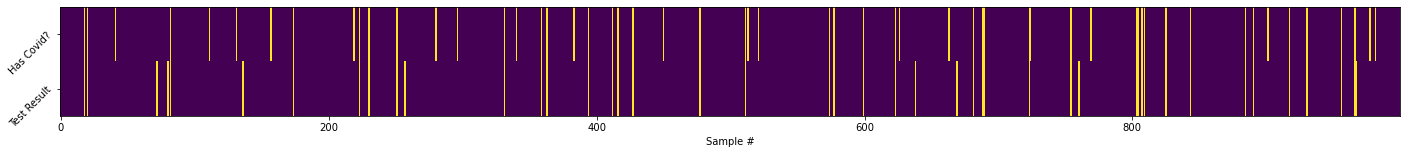

In [13]:
fig, ax = plt.subplots( figsize = (24, 2) )
sample_plot( ax, has_covid_suspicious, rtpcr_positive_suspicious )
plt.show()

Already this is looking much more reasonable. **What are the PPV and the NPV**?

In [14]:
ppv_suspicious, npv_suspicious = predictive_value( has_covid_suspicious, rtpcr_positive_suspicious )

print( f'Suspicious PPV: {ppv_suspicious * 100:0.2f}%' )
print( f'Suspicious NPV: {npv_suspicious * 100:0.2f}%' )

Suspicious PPV: 82.22%
Suspicious NPV: 98.01%


## Aha!

The PPV has jumped dramatically, from about 18% to about 82%! In this setting—where we have some **additional knowledge** about who we're testing—the **same exact test** has become **a lot more useful**.

#### N.B.

There is no free lunch, of course; the cost we pay is that the NPV in this scenario is now *slightly* lower!

The critical takeaway message is this:

## How useful a test is depends on our prior belief about the thing we're testing for.

# TODO: Re-tooling here and below

### Bayes' Rule and the Importance of Priors

The reason that this happens is because of **Bayes' rule**, which enables us to "flip" our assumptions about different probabilities. In the setting of Covid tests, Bayes' rule takes the form

$$ \mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+) = \frac{\mathrm{Pr}(\textrm{test }+ \mid \textrm{actually }+)\,\mathrm{Pr}(\textrm{actually }+)}{\mathrm{Pr}(\textrm{test }+)} $$

We know what a couple of these terms are. On the left, we have the PPV; and in the numerator on the right, the first term is the sensitivity. So, Bayes' rule actually links these two quantities together:

$$ \mathrm{PPV} = \frac{\mathrm{sensitivity}\cdot\mathrm{Pr}(\textrm{actually }+)}{\mathrm{Pr}(\textrm{test }+)} $$

So we see that the PPV **explicitly depends on the probability of the person we test having Covid**: increasing our **prior belief** of whether the person we're testing has Covid (e.g., by changing our testing scheme to only test people with exposures) increases the PPV, while decreasing our prior belief decreases the PPV.

Put together, this means that PPV is *not just a statement about the test*: it is **a statement about how the test is used**.

We can use simulations to plot this dependence:

In [19]:
# Fancy progress bar!
from tqdm import tqdm

n_sample_sweep = 1000

# We'll test a bunch of different levels of belief, spaced between 0 and 0.25
covid_beliefs_sweep = np.linspace( 0, 0.25, 50 )

# At each level of belief, we'll run `n_sims` number of simulations, to get
# a solid distribution
n_sims = 100
# Pre-allocate all of the results we're going to get; we'll fill this in as we go!
ppvs_sweep = np.zeros( (len( covid_beliefs_sweep ), n_sims) )
npvs_sweep = np.zeros( (len( covid_beliefs_sweep ), n_sims) )

# `tqdm` turns any iterable into a progress bar!
# `enumerate` doesn't know how long its contents are (they can be infinite!),
# so we have to tell `tqdm` how long it is if we want it to show the total
for i_sweep, covid_belief in tqdm( enumerate( covid_beliefs_sweep ),
                                   total = len( covid_beliefs_sweep ) ):
    
    for i_sim in range( n_sims ):
    
        has_covid_sweep, rtpcr_positive_sweep = sample_results( n_sample_sweep,
                                                                covid_belief,
                                                                rtpcr_sensitivity,  # Same as before!
                                                                rtpcr_specificity ) # Same as before!

        ppvs_sweep[i_sweep, i_sim], npvs_sweep[i_sweep, i_sim] = predictive_value( has_covid_sweep, rtpcr_positive_sweep )

100%|██████████| 50/50 [00:01<00:00, 39.45it/s]


In [20]:
# A convenience function for plotting a band with mean +/- SD
def plot_band( ax, x, mean, std,
               color = '',
               kwargs_plot = dict(),
               kwargs_fill = dict() ):
    
    # `**kwargs_plot` tells Python to pass this dict to `plot` as keyword arguments
    # This makes it so that I can control any behavior of `plot` (and `fill_between`, below)
    # without having to explicitly write out every argument I want to control beforehand!
    ax.plot( x, mean, f'{color}-', **kwargs_plot )
    ax.fill_between( x, mean - std, mean + std,
                     color = color,
                     alpha = 0.2,
                     **kwargs_fill )

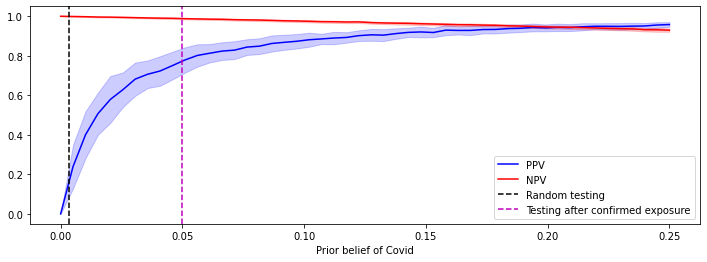

In [21]:
ppvs_sweep_mean = np.mean( ppvs_sweep, axis = 1 )
ppvs_sweep_std = np.std( ppvs_sweep, axis = 1 )
npvs_sweep_mean = np.mean( npvs_sweep, axis = 1 )
npvs_sweep_std = np.std( npvs_sweep, axis = 1 )

fig, ax = plt.subplots( figsize = (12, 4) )

# Here I pass in the 'label' keyword argument so that `matplotlib` makes a nice legend when
# I call `legend` below
plot_band( ax, covid_beliefs_sweep, ppvs_sweep_mean, ppvs_sweep_std, 'b',
           kwargs_plot = { 'label': 'PPV'} )
plot_band( ax, covid_beliefs_sweep, npvs_sweep_mean, npvs_sweep_std, 'r',
           kwargs_plot = { 'label': 'NPV'} )

# Just going to plot a couple of vertical lines to showcaase where our examples were
yl = ax.get_ylim()
ax.plot( [covid_prevalence, covid_prevalence],
         yl,
         'k--',
         label = 'Random testing' )
ax.plot( [covid_belief_suspicious, covid_belief_suspicious],
         yl,
         'm--',
         label = 'Testing after confirmed exposure' )

ax.set_ylim( yl )

ax.set_xlabel( 'Prior belief of Covid' )

ax.legend()

plt.show()

We can see from the left-hand side of this curve that even **very weak improvements in our prior belief** can lead to **vast changes in the utility of our test**!

---

We use statistical tests all the time in science. When we get the result of a test, we ideally would like to **infer** something about the world we live in based on the result of the test. Just like for the PPV:

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually }+ \mid \textrm{test }+) $$

what we're looking for in science is, taking as given *some bit of information we saw* (e.g., "a $t$-test rejects the null hypothesis at $p < 0.05$"), how confident are we about some statement about the world (e.g., "gamma oscillations are larger in amplitude in the decision period"). This is exactly analogous to the PPV in the Covid test case:

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually a difference} \mid \textrm{test rejects null hypothesis}) $$

Because of Bayes' rule, we know that

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually a difference} \mid \textrm{test rejects null hypothesis}) = \frac{\mathrm{Pr}(\textrm{test rejects null hypothesis} \mid \textrm{actually a difference})\,\mathrm{Pr}(\textrm{actually a difference})}{\mathrm{Pr}(\textrm{test rejects null hypothesis})} $$

Just as the PPV in the Covid test scenario depended on our prior knowledge of whether the person being tested had Covid, **the PPV of our statistical test depends on our prior knowledge of whether the difference we're looking for is real**.

Let's say I go out into the world and start using the `correlation` function between every pair of two datasets I can get my hands on. The probability that any two of those randomly chosen datasets are **actually** causally related to one another, $\mathrm{Pr}(\textrm{actually a relationship})$, is *astronomically small*. So when I stumble upon a pair where, after plugging all the data into the appropriate MATLAB toolbox, I excitedly check in the terminal

what do I actually *take away* from this? What can I infer about the *actual* relationship between the two things I checked? Put in terms we've seen: what is

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{actually a relationship} \mid \textrm{test shows that }p < 0.05) $$

Just like in the situation with random Covid testing, because the prior probability of there being a relationship is so astronomically small, **the PPV of testing random correlations will be exceedingly low**: that is, most of the times when I run the test and show a positive result—a significant correlation!—**the result will be a false positive**. Because the prior is so low, this test is not informative: I cannot draw any useful conclusions after running the statistics.

It's important to remember, though, that this **is not a statement about the test**. This isn't a bad statistical test, in much the same way as the RT-PCR is **not** a bad test for Covid. Rather, the issue is with **how the test is used**. In order to make any statistical test's results meaningful—that is, in order to ensure that the positive predictive value is high enough to enable us to draw *inferences* about the world from the results—we need to use the test in some kind of intelligent scheme, like the above example with testing after *exposures*, that gives us a little bit of *prior knowledge*. It doesn't have to be much: as we saw above, even just improving our suspicion of Covid to 5%—very weak information about the diagnosis—dramatically improved the usefulness of the RT-PCR test, with the PPV jumping from 16% to 82%—**for the exact same test**!

Statistical testing is not just a matter of selecting the "correct" test for a given question. Being judicious about selecting the correct **questions** to apply the test *to* is a more powerful way to strengthen the inferences gained through statistics, to improve the reproducibility of science, and to more responsibly use resources, like experimental animals, that we are ethically obligated to minimize.

---

### Follow-Up Questions

For fun 🙃.

#### Decision theory

> What is a "good" positive or negative predictive value, quantitatively?

> What do we do once we get a test result?

> Are false positives and false negatives equally bad? Which should we prioritize making as large as possible, PPV or NPV?

#### Experimental design

> How do we know whether our belief about the prevalence of Covid is correct? How do we know how accurate our prior belief about a statement in science is?

> **How do we choose the next test to run?**

#### Accumulating evidence

> Let's say we run a second experiment with a second test. Now we can use Bayes' rule to find that
> 
> $$
\begin{eqnarray*}
    \mathrm{Pr}(\textrm{statement } \mid \textrm{test 1 }+) & = & \frac{\mathrm{Pr}(\textrm{test 1 }+ \mid \textrm{statement})\,\mathrm{Pr}(\textrm{statement})}{\mathrm{Pr}(\textrm{test 1 }+)} \\
    \mathrm{Pr}(\textrm{statement } \mid \textrm{test 1 }+,\textrm{test 2 }+) & = & \frac{\mathrm{Pr}(\textrm{test 2 }+ \mid \textrm{statement}, \textrm{test 1 }+)\,\mathrm{Pr}(\textrm{statement} \mid \textrm{test 1 }+)}{\mathrm{Pr}(\textrm{test 2 }+)} \\
    \mathrm{Pr}(\textrm{statement } \mid \textrm{test 1 }+,\textrm{test 2 }+,\textrm{test 3 }+) & = & \cdots
\end{eqnarray*}
$$
>
> And so on, for test after test. That is, we can **update** our belief using the evidence from each successive test. How deep does this rabbit hole go? What does this process converge to? What does this convergence depend on? Does it converge at all?
>
> <img src="figures/ppv/f2.png" style="display: block;margin-left: auto;margin-right: auto;width: 65%;" />

> Let's say we *update* our belief with successive tests, as above, but at each step, we choose the next test such that it will maximally increase our updated probability, $\mathrm{Pr}(\textrm{statement} \mid \textrm{tests})$—that is, we choose the experiment that we think will give us the most evidence supporting our model. What does this process converge to?

> Let's say we *update* our belief with successive tests, as above, but at each step, we choose the next test **completely at random**. What does this process converge to?

> Let's say we *update* our belief with successive tests, but we are **really wrong** about our initial belief. What happens to the limit? Will it always end up in the same place at the end of the process? What is the best initial belief to have?

#### Comparing models

> Let's say we *update* our belief with successive tests, but this time, we look at **multiple** candidate models; i.e., we obtain
>
> $$
\begin{eqnarray*}
    &\mathrm{Pr}(\textrm{model 1} \mid \textrm{test 1},\cdots,\textrm{test }n) \\
    &\mathrm{Pr}(\textrm{model 2} \mid \textrm{test 1},\cdots,\textrm{test }n) \\
    &\cdots \\
    &\mathrm{Pr}(\textrm{model }k \mid \textrm{test 1},\cdots,\textrm{test }n)
\end{eqnarray*}
$$
>
> Does the presence of multiple candidate models change the way we should choose the next test?
>
> <img src="figures/ppv/f3.png" style="display: block;margin-left: auto;margin-right: auto;width: 65%;" />

> In the above scheme with multiple candidate models, let's say that the **truth** is **not** among the models that you considered. What does this process converge to? How do you interpret the result? How do you know whether you included the truth as a candidate model?

#### History dependence

The process of updating our beliefs about our model is kind of like an optimization problem: there is some "landscape" painted across the space of all models we're considering, with the "height" at each point (each model) corresponding to the "badness" of that model—for example, the model's *prediction error*. Our goal is to incrementally update what we *think* the model is in order to find the lowest point—the "best" model—in the hopes that this is the **truth**.

<img src="figures/ppv/f4.png" style="display: block;margin-left: auto;margin-right: auto;width: 65%;" />

> After each experiment we run, we collect new data. This data changes how we measure the badness or goodness of a model's fit, which **alters the landscape** of our optimization problem.
>
> <img src="figures/ppv/f5.png" style="display: block;margin-left: auto;margin-right: auto;width: 65%;" />
>
> What happens if we start off very wrong about our prediction of what model is best? Does our optimization process converge to the truth? How can we ever "recover"?

> Is this new minimum *actually* the truth? That is, was our notion of truth—our "landscape"—wrong to begin with? Was the evidence that "eroded" the landscape actually *helpful*? Or was this erosion a result of our bias from an incorrect prediction?

> **How does the optimum we converge to depend on how we choose the next test to run?**

> If we had lived in a world with a vastly different initial prediction, would **yet another** minimum have emerged? Is *that* the truth?

> Is there a criterion for optimality that is independent of our starting position? Can we design a scheme for conducting tests that makes us more likely to converge to the "optimum" model according to that criterion?

> Is any of this even a problem? Should we try to design scientific inquiry so that this effect is minimized? Or is this an important feature of how science behaves? Is the model we converge to through this process a statement about the world we live in, or just a statement about the process *itself*?

> What would scientific "truth" look like today if we had had different structures in place for how we conduct science all along? What amazing ideas have we missed out on?

In many situations, we use data to **test** (that is, make a binary decision about) whether a statement is true or false. Recall that there is a *big disconnect* between whether the statement is *actually* true, and whether a particular test *claims* that the statement is true. This happens because of **randomness** in the test results.

Really, though, we don't care about the result of the test *per se*. What we want to do is **infer**, based on the result of the test, some kind of truth about *what universe we live in*. The **positive predictive value** quantifies our ability to make this inference: it is the knowledge you glean about whether the statement is true when your test *suggests* to you that the statement is true. Quantitatively, PPV is the probability that the statement is *actually* true **given** that you saw test results indicating that the statement is true; that is,

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{the statement is true} \mid \textrm{the test claims the statement is true}) $$

> This uses the notation of **conditional probability**: the notation
>
> $$ \mathrm{Pr}(X \mid Y) $$
>
> is interpreted as "The probability that $X$ is true **given** that we know for certain that $Y$ is true." This doesn't necessarily tell us that $Y$ *is actually* true; it's what would happen to our knowledge of $X$ *if we assume* that $Y$ is true.
>
> <img src="figures/ppv/f1.png" />

In science, where we take *samples* of data to make inferences about an entire *population*, we might phrase this as something like

$$ \mathrm{PPV} = \mathrm{Pr}(\textrm{there is an effect in the population} \mid \textrm{you see an effect in your sample}) $$

Importantly, though, we **assume as given** the test result. We know the result of the test as a certain fact, because it is the data we saw with our own eyes!

Notice that this is **very different** from what is measured with a $p$-value. The $p$-value is the *false positive rate* **under the hypothetical assumption that there is, in fact, no effect in the population**; that is,

$$ p = \mathrm{Pr}(\textrm{you see an effect in your sample} \mid \textrm{there is no effect in the population}) $$

The conditioning is **backwards**: here, we make our assumption about *what universe we live in*, not *what data we obtained*.

This formalism is convenient, because often we can make pretty good assumptions about the **disitribution** of our data if we take it as a given that there is no effect. Even when all of our heavy-hitting tools fail, we can almost always fall back on *approximating* that distribution by randomly jumbling up all of the labels on our data to **artificially impose** a condition where there is truthfully no effect. This scheme is known as **permutation testing**.

But even though it's convenient, the way the $p$-value is constructed isn't really how science works in the real world: after all, we *don't know* what world we live in. (We want to find out—that's the whole point of science!) But we *do know* what data we record from our experiments, as well as the test results that we derive from that data. What we want to do is **infer** something about the universe **given**—or, conditional upon—the data that we have obtained. How do we translate back and forth between these two pictures, with the conditioning flipped?